# Name: Mohamed Mahmoud Rezk
# ID: 2002114

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

## metrics imports
import sklearn.metrics as metrics 

%matplotlib inline

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [3]:
data.columns

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')

In [4]:
data.shape

(863, 15)

### Dropping the `Unnamed: 0` column 

In [5]:
data.drop(columns=["Unnamed: 0"], inplace=True)

### Looking at the description of the data

In [6]:
data.describe()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.00000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,76.645423,16.995365,0.849363,49.400000,0.181924,0.107764,12.13905,28.002317,18.298957,11.840093,2.993048,0.998841,0.995365,0.125145
std,39.200264,7.809951,0.726062,15.079203,0.386005,0.310261,3.99787,7.473231,2.864064,1.183771,0.127251,0.034040,2.358767,0.331075
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000
25%,45.000000,11.000000,0.000000,40.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
50%,87.000000,18.000000,1.000000,49.400000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,0.000000,0.000000
75%,110.000000,24.000000,1.000000,57.000000,0.000000,0.000000,14.00000,31.000000,19.000000,12.000000,3.000000,1.000000,1.000000,0.000000
max,138.000000,33.000000,2.000000,96.000000,1.000000,1.000000,24.00000,31.000000,19.000000,12.000000,3.000000,1.000000,15.000000,1.000000


In [7]:
print("Unique Values for each column")
print("-----------------------------")
for col in data.columns:
    print(col, data[col].nunique())

Unique Values for each column
-----------------------------
location 139
country 34
gender 3
age 81
vis_wuhan 2
from_wuhan 2
symptom1 25
symptom2 32
symptom3 20
symptom4 13
symptom5 4
symptom6 2
diff_sym_hos 18
result 2


### Show correlation heatmap between training features

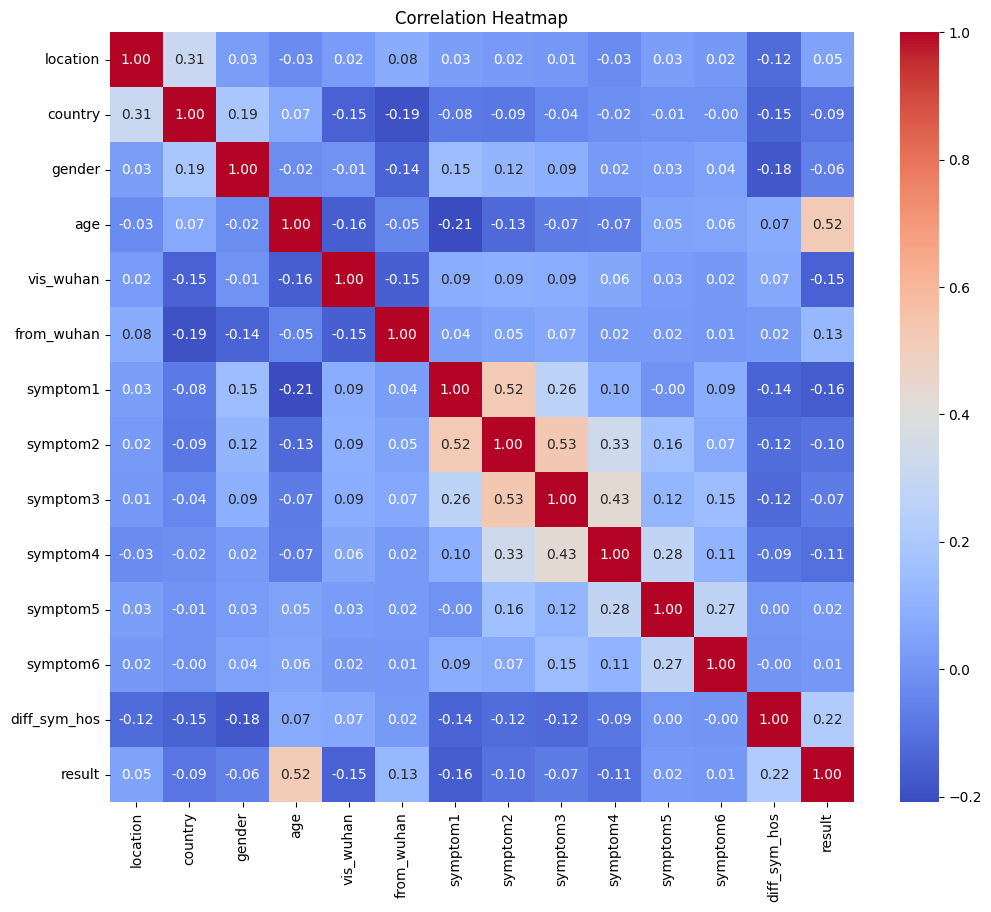

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## Observations

### PROBLEM 1: There is a third gender (value of `2`)  

In [9]:
data["gender"].value_counts()

gender
1    389
0    302
2    172
Name: count, dtype: int64

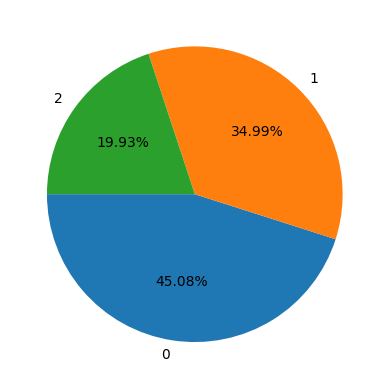

In [10]:
plt.pie(data["gender"].value_counts(), labels=[0,1,2], startangle=180, autopct="%2.2f%%")
plt.show()

#### FIX: Since the "third/undefined" gender takes around 20% of the data, the `gender` column can be omitted

In [11]:
data.drop(columns=["gender"], inplace=True)

### PROBLEM 2: the min value of `diff_sym_hos` column is negative

In [12]:
data[data["diff_sym_hos"] < 0]

,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
223,56,18,35.0,0,0,6,31,19,12,3,1,-1,0
240,128,18,65.0,0,0,6,31,19,12,3,1,-5,0


#### FIX: Dropping rows that have negative values in `diff_sym_hos` column

In [13]:
negative_diff_idxs = data[data["diff_sym_hos"] < 0].index.values.tolist()
data.drop(index=negative_diff_idxs, inplace=True)
data.shape

(861, 13)

### PROBLEM 3: `symptom5` and `symptom6` column experience no variation with almost zero correlation with `result` 

In [14]:
data["symptom5"].value_counts()

symptom6
1    860
0      1
Name: count, dtype: int64

In [14]:
data["symptom6"].value_counts()

symptom6
1    860
0      1
Name: count, dtype: int64

#### FIX: dropping the `symptom5` and `symptom6` columns

In [15]:
data.drop(columns=["symptom5", "symptom6"], inplace=True)
data.shape

(861, 12)

## Preparing features for training

In [16]:
X = (data.loc[:, data.columns != "result"]).to_numpy()
y = data["result"].to_numpy()
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=44)

### Normalizing training data (0 mean and 1 std)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[ 2.00098336e-17  3.25966644e-17 -1.20031569e-14  6.66456554e-17
  1.06665323e-16 -1.30225288e-16 -3.85350666e-16 -4.50543995e-16
  4.93145576e-16  1.11506411e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Preparing mertics functions

In [18]:
CLASSIFIERS_SCORES = {}
metrics_funcs = {
    "Accuracy": metrics.accuracy_score,
    "Precision": metrics.precision_score,
    "Recall": metrics.recall_score,
    "F1-score": metrics.f1_score,
}

def compute_model_metrics(y_true, y_pred):
    res = dict()
    for metric in metrics_funcs:
        res[metric] = metrics_funcs[metric](y_true, y_pred)
    return pd.DataFrame(res.items())

def display_confusion_matrix(y_true, y_pred):
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=[0,1])
    plt.show()

def display_roc_graph(model, X_test, y_test):
    dis = metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    dis.ax_.plot([0,1], [0,1], "r--")
    plt.grid()
    plt.show()


# K-Nearest Neighbours Classifier

### Finding the best K with grid search and cross validation. Usually, the best K is smaller than $\sqrt{N}$ where $N$ is number of training samples

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

maxk = np.ceil(np.sqrt(X_train.shape[0]) + 1)
knn = KNeighborsClassifier()
param_grid_knn = {
    "n_neighbors": np.arange(1, int(maxk)),
    "weights": ["distance", "uniform"],    
}
knn_cv = GridSearchCV(knn, param_grid_knn, cv=7, verbose=1, scoring="roc_auc")
knn_cv.fit(X_train, y_train)
best_params_knn = knn_cv.best_params_
print("Tuned knn parameters:", best_params_knn)

Fitting 7 folds for each of 54 candidates, totalling 378 fits
Tuned knn parameters: {'n_neighbors': 10, 'weights': 'distance'}


### Compute knn model metrics using the `best_k` and `best_weight`

In [20]:
knn_tuned = KNeighborsClassifier(**best_params_knn)
knn_tuned.fit(X_train, y_train)
y_pred_knn = knn_tuned.predict(X_test)
knn_metrics = compute_model_metrics(y_test, y_pred_knn)
CLASSIFIERS_SCORES["KNN"] = knn_metrics
print("KNN Metrics")
print(knn_metrics)

KNN Metrics
           0         1
0   Accuracy  0.971098
1  Precision  0.842105
2     Recall  0.888889
3   F1-score  0.864865


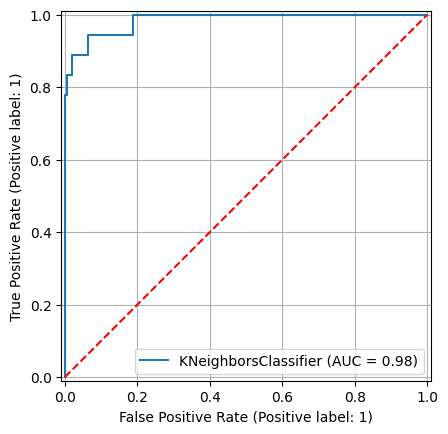

In [21]:
display_roc_graph(knn_tuned, X_test, y_test)

In [22]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       155
           1       0.84      0.89      0.86        18

    accuracy                           0.97       173
   macro avg       0.91      0.93      0.92       173
weighted avg       0.97      0.97      0.97       173



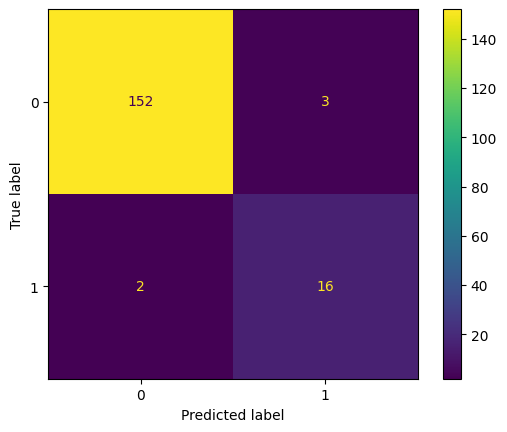

In [23]:
display_confusion_matrix(y_test, y_pred_knn)

# Logistic Regression Classifier

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
param_grid_lr = {
    # from .001 to 1000
    "C": np.logspace(-3, 3, 7),
    "solver": ["newton-cg", "lbfgs", "liblinear"],
    "penalty": ["l2"]
}
lr_cv = GridSearchCV(lr, param_grid_lr, cv=7, verbose=1, scoring="roc_auc")
lr_cv.fit(X_train, y_train)
best_params_lr = lr_cv.best_params_
print("Tuned parameters:", best_params_lr)


Fitting 7 folds for each of 21 candidates, totalling 147 fits
Tuned parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [25]:
lr_tuned = LogisticRegression(**best_params_lr)
lr_tuned.fit(X_train, y_train)
y_pred_lr = lr_tuned.predict(X_test)
lr_metrics = compute_model_metrics(y_test, y_pred_lr)
CLASSIFIERS_SCORES["LogisiticRegression"] = lr_metrics
print("Logisitic Regression Metrics")
print(lr_metrics)

Logisitic Regression Metrics
           0         1
0   Accuracy  0.942197
1  Precision  0.681818
2     Recall  0.833333
3   F1-score  0.750000


In [26]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       155
           1       0.68      0.83      0.75        18

    accuracy                           0.94       173
   macro avg       0.83      0.89      0.86       173
weighted avg       0.95      0.94      0.94       173



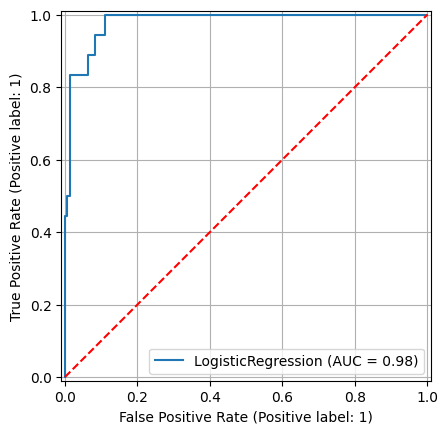

In [27]:
display_roc_graph(lr_tuned, X_test, y_test)


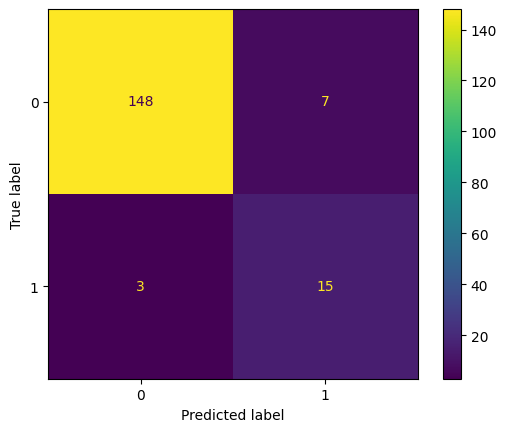

In [28]:
display_confusion_matrix(y_test, y_pred_lr)